In [1]:
import shap
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearnex import patch_sklearn, config_context
patch_sklearn()


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
merged_path = "../data/plankton-patrol/Plankton Patrol/Data/plank_Chesapeake_buoywater_merged.csv"
data = pd.read_csv(merged_path)

In [3]:
len(data)

1304147

In [4]:
# create time column from sample_year, sample_month, sample_day, sample_hour, sample_minute, sample_second
data['Time'] = pd.to_datetime(dict(year=data.Sample_year,month= data.Sample_month,day=data.Sample_day,hour=data.Sample_hour,minute=data.Sample_minute,second=data.Sample_second))

data = data.resample('h',on='Time').mean().dropna(how='all')
len(data)

133422

In [5]:
# merge columns from two datasets - they do not overlap
data['Chlorophyll_Merged'] = data['Chlorophyll'].fillna(data['CHLA'])
data = data.drop(columns=['Chlorophyll','CHLA'])
data = data.rename(columns={'Chlorophyll_Merged': 'Chlorophyll'})

data['Salinity_Merged'] = data['Salinity'].fillna(data['SALINITY'])
data = data.drop(columns=['Salinity','SALINITY'])
data = data.rename(columns={'Salinity_Merged': 'Salinity'})

data['Wtemp_Merged'] = data['Temperature'].fillna(data['WTEMP'])
data = data.drop(columns=['Temperature','WTEMP'])
data = data.rename(columns={'Wtemp_Merged': 'Temperature'})

data['DO_Merged'] = data['Oxygen'].fillna(data['DO'])
data = data.drop(columns=['Oxygen','DO'])
data = data.rename(columns={'DO_Merged': 'Oxygen'})

In [6]:
data.columns

Index(['Air Temperature', 'Air pressure', 'Humidity', 'Wind speed',
       'Wind Direction', 'Turbidity', 'Significant wave height',
       'Wave from direction', 'Wave period', 'North surface currents',
       'East surface currents', 'Sample_year', 'Sample_month', 'Sample_day',
       'Sample_hour', 'Sample_minute', 'Sample_second', 'Latitude',
       'Longitude', 'TotalDepth', 'UpperPycnocline', 'LowerPycnocline',
       'Depth', 'DIN', 'DOC', 'DON', 'DOP', 'DO_SAT_P', 'FSS', 'KD', 'NH4F',
       'NO23F', 'NO2F', 'NO3F', 'PC', 'PH', 'PHEO', 'PN', 'PO4F', 'PP',
       'SECCHI', 'SIF', 'SIGMA_T', 'SPCOND', 'TDN', 'TDP', 'TN', 'TON', 'TP',
       'TSS', 'VSS', 'Chlorophyll', 'Salinity', 'Temperature', 'Oxygen'],
      dtype='object')

In [7]:
data = data.drop(columns=['Wind Direction','Wave from direction','Sample_minute','Sample_second'])

In [8]:
data.columns

Index(['Air Temperature', 'Air pressure', 'Humidity', 'Wind speed',
       'Turbidity', 'Significant wave height', 'Wave period',
       'North surface currents', 'East surface currents', 'Sample_year',
       'Sample_month', 'Sample_day', 'Sample_hour', 'Latitude', 'Longitude',
       'TotalDepth', 'UpperPycnocline', 'LowerPycnocline', 'Depth', 'DIN',
       'DOC', 'DON', 'DOP', 'DO_SAT_P', 'FSS', 'KD', 'NH4F', 'NO23F', 'NO2F',
       'NO3F', 'PC', 'PH', 'PHEO', 'PN', 'PO4F', 'PP', 'SECCHI', 'SIF',
       'SIGMA_T', 'SPCOND', 'TDN', 'TDP', 'TN', 'TON', 'TP', 'TSS', 'VSS',
       'Chlorophyll', 'Salinity', 'Temperature', 'Oxygen'],
      dtype='object')

In [9]:
X, y = data.drop(['Chlorophyll'], axis=1), data['Chlorophyll']

In [10]:
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.01, 0.001, 0.0001],
    "n_estimators": [50, 100, 200],
}
boosting_models = {
    "LightGBM": (
        lgb.LGBMRegressor(min_gain_to_split=0.1, force_col_wise=True),
        {
            "max_depth": [3, 5, 7],
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.1, 0.01, 0.001, 0.0001],
        },
    ),
    "XGBoost": (
        xgb.XGBRegressor(device="cuda", enable_categorical=True),
        {
            "max_depth": [3, 5, 7],
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.1, 0.01, 0.001, 0.0001],
        },
    ),
}


nn_models = {
     "MLPRegressor": (
        MLPRegressor(max_iter=200, verbose=True),
        {
            "hidden_layer_sizes": [(25, 25), (50,)],
            "learning_rate_init": [0.001, 0.01],
        },
    ),
}


# Make custom scorer
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

best_models = {}
kf = KFold(n_splits=5)

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numerical_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline([("scaler", StandardScaler()), ("imputer", SimpleImputer())]),
            numerical_features,
        ),  # Impute missing values in numerical features
        (
            "cat",
            Pipeline(
                [
                    (
                        "imputer",
                        SimpleImputer(strategy="most_frequent"),
                    ),  # Impute missing values in categorical features
                    (
                        "onehot",
                        OneHotEncoder(handle_unknown="ignore"),
                    ),  # One-hot encode categorical features
                ]
            ),
            categorical_features,
        ),
    ]
)

In [12]:
# # Define the cuML MLPRegressor
# def create_cuml_mlp(hidden_layer_sizes=(64,), learning_rate=0.01):
#     return cumlMLPRegressor(hidden_layer_sizes=hidden_layer_sizes, solver='adam', learning_rate_init=learning_rate)


In [13]:
def run_all(models, savepath="../data/results/grid"):
    os.makedirs(savepath, exist_ok=True)
    print(models, flush=True)
    mse_scores = []
    kfold_bestparams = []
    allshapvalues = []
    for model_name, (model, param_grid) in models.items():
        print("MODEL NAME: ", model_name)

        # Create a GridSearchCV object
        grid_search = GridSearchCV(
            estimator=model, param_grid=param_grid, cv=kf, scoring=mse_scorer
        )
        if model_name == "MLPRegressor":
            X_calc = preprocessor.fit_transform(X)

        else:
            X_calc = X.__deepcopy__()
            # grid_search.fit(X_calc, y)
        with config_context(target_offload="gpu:0"):
            grid_search.fit(X_calc, y)

        best_model = grid_search.best_estimator_
        results_df = pd.DataFrame(grid_search.cv_results_)

        # Store the best model and its parameters
        best_models[model_name] = {
            "best_estimator": best_model,
            "best_parameters": grid_search.best_params_,
            "best_score": grid_search.best_score_,
            "cv_results": results_df,
        }
        results_df = pd.DataFrame(grid_search.cv_results_)
        results_df.to_csv(
            os.path.join(savepath, "gridsearch_cv_results.csv"), index=False
        )

        for k, v in best_models[model_name].items():
            print(f"{k} : {v}")

        # print(f"MSE with Best Parameters: {best_models[model_name]['best_score']}")
        mse_scores.append(best_models[model_name]["best_score"])
        kfold_bestparams.append(best_models[model_name]["best_parameters"])
        shap_values = None
        plt.figure()
        if model_name == "MLPRegressor":
            explainer = shap.KernelExplainer(model=best_model.predict, data=X_calc)
            # shap_values = explainer(X_calc)
        else:
            explainer = shap.Explainer(model=best_model, masker=X_calc)
            shap_values = explainer(X_calc, check_additivity=False)

            plt.savefig(
                os.path.join(savepath, f"shap_explainer_best_{model_name}.png"),
                bbox_inches="tight",
            )
            plt.close()
            allshapvalues.append(shap_values)
            explainer.__class__

            plt.figure()
            shap.summary_plot(shap_values, X_calc, show=False)
            plt.savefig(
                os.path.join(savepath, f"shap_summary_plot_best_{model_name}.png"),
                bbox_inches="tight",
            )
            plt.close()
    return mse_scores, kfold_bestparams, allshapvalues, best_models

In [14]:
b_mse_scores, b_kfold_bestparams, b_allshapvalues, b_best_models = run_all(
    boosting_models
)

{'LightGBM': (LGBMRegressor(force_col_wise=True, min_gain_to_split=0.1), {'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001, 0.0001]}), 'XGBoost': (XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), {'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200], 'lear

 99%|===================| 132097/133422 [01:21<00:00]        

MODEL NAME:  XGBoost


c:\Users\pushk\anaconda3\envs\plankton\lib\site-packages\xgboost\core.py:158: UserWarning: [17:01:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


best_estimator : XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
best_parameters : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
best_score : -32.42928964830753
cv_results :     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.257523      0.038260         0.022399   

100%|===================| 132811/133422 [00:43<00:00]        

In [17]:
m_mse_scores , m_kfold_bestparams, m_allshapvalues, m_best_models =run_all(nn_models)

{'MLPRegressor': (MLPRegressor(verbose=True), {'hidden_layer_sizes': [(25, 25), (50,)], 'learning_rate_init': [0.001, 0.01]})}
MODEL NAME:  MLPRegressor
Iteration 1, loss = 21.19205436
Iteration 2, loss = 15.74811822
Iteration 3, loss = 14.64479357
Iteration 4, loss = 13.50918392
Iteration 5, loss = 12.58645881
Iteration 6, loss = 11.82974984
Iteration 7, loss = 11.26210341
Iteration 8, loss = 10.82213006
Iteration 9, loss = 10.45780100
Iteration 10, loss = 10.17910630
Iteration 11, loss = 9.95123179
Iteration 12, loss = 9.73629122
Iteration 13, loss = 9.56364911
Iteration 14, loss = 9.39380324
Iteration 15, loss = 9.23185170
Iteration 16, loss = 9.08650219
Iteration 17, loss = 8.95332519
Iteration 18, loss = 8.83350582
Iteration 19, loss = 8.73726827
Iteration 20, loss = 8.62162970
Iteration 21, loss = 8.53467242
Iteration 22, loss = 8.44540690
Iteration 23, loss = 8.36727419
Iteration 24, loss = 8.29857349
Iteration 25, loss = 8.22615752
Iteration 26, loss = 8.18162537
Iteration 27, 

c:\Users\pushk\anaconda3\envs\plankton\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 17.77072269
Iteration 2, loss = 13.86567416
Iteration 3, loss = 12.80753397
Iteration 4, loss = 12.01635630
Iteration 5, loss = 11.25249976
Iteration 6, loss = 10.60286561
Iteration 7, loss = 10.01153867
Iteration 8, loss = 9.51983588
Iteration 9, loss = 9.10774043
Iteration 10, loss = 8.73471965
Iteration 11, loss = 8.45958842
Iteration 12, loss = 8.17849298
Iteration 13, loss = 7.95971914
Iteration 14, loss = 7.75897575
Iteration 15, loss = 7.58595168
Iteration 16, loss = 7.40558378
Iteration 17, loss = 7.27444312
Iteration 18, loss = 7.21224709
Iteration 19, loss = 7.04417277
Iteration 20, loss = 6.95872385
Iteration 21, loss = 6.94712855
Iteration 22, loss = 6.82712149
Iteration 23, loss = 6.71947517
Iteration 24, loss = 6.67110152
Iteration 25, loss = 6.63498435
Iteration 26, loss = 6.55120490
Iteration 27, loss = 6.52471358
Iteration 28, loss = 6.48174287
Iteration 29, loss = 6.41553432
Iteration 30, loss = 6.37397802
Iteration 31, loss = 6.33213693
Iteration 

c:\Users\pushk\anaconda3\envs\plankton\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 22.25003012
Iteration 2, loss = 16.67372232
Iteration 3, loss = 15.68343869
Iteration 4, loss = 14.74968673
Iteration 5, loss = 13.84562280
Iteration 6, loss = 13.09367587
Iteration 7, loss = 12.40128494
Iteration 8, loss = 11.85793207
Iteration 9, loss = 11.42286976
Iteration 10, loss = 10.98063750
Iteration 11, loss = 10.60755421
Iteration 12, loss = 10.31240216
Iteration 13, loss = 10.00999369
Iteration 14, loss = 9.80494487
Iteration 15, loss = 9.51926292
Iteration 16, loss = 9.33501178
Iteration 17, loss = 9.18825227
Iteration 18, loss = 9.03928085
Iteration 19, loss = 8.94266257
Iteration 20, loss = 8.79122154
Iteration 21, loss = 8.72474531
Iteration 22, loss = 8.59266407
Iteration 23, loss = 8.52231431
Iteration 24, loss = 8.43529060
Iteration 25, loss = 8.34412717
Iteration 26, loss = 8.28692036
Iteration 27, loss = 8.22409045
Iteration 28, loss = 8.14587411
Iteration 29, loss = 8.09561082
Iteration 30, loss = 8.05206857
Iteration 31, loss = 8.04302407
Iter

c:\Users\pushk\anaconda3\envs\plankton\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 13.60285232
Iteration 3, loss = 12.76455199
Iteration 4, loss = 12.19786290
Iteration 5, loss = 11.73371343
Iteration 6, loss = 11.24344602
Iteration 7, loss = 10.72299751
Iteration 8, loss = 10.22217577
Iteration 9, loss = 9.86595774
Iteration 10, loss = 9.50133336
Iteration 11, loss = 9.19591961
Iteration 12, loss = 8.93642494
Iteration 13, loss = 8.74348531
Iteration 14, loss = 8.55085120
Iteration 15, loss = 8.37829973
Iteration 16, loss = 8.23535061
Iteration 17, loss = 8.14142137
Iteration 18, loss = 7.98919820
Iteration 19, loss = 7.89071992
Iteration 20, loss = 7.82411079
Iteration 21, loss = 7.75193971
Iteration 22, loss = 7.67538949
Iteration 23, loss = 7.59684751
Iteration 24, loss = 7.55621063
Iteration 25, loss = 7.45356055
Iteration 26, loss = 7.47959892
Iteration 27, loss = 7.37746470
Iteration 28, loss = 7.37486222
Iteration 29, loss = 7.37437193
Iteration 30, loss = 7.24284858
Iteration 31, loss = 7.20999953
Iteration 32, loss = 7.40232023
Iteration

c:\Users\pushk\anaconda3\envs\plankton\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 8.75604574
Iteration 3, loss = 8.08501838
Iteration 4, loss = 7.57005043
Iteration 5, loss = 7.14145299
Iteration 6, loss = 6.79873202
Iteration 7, loss = 6.53504936
Iteration 8, loss = 6.32846904
Iteration 9, loss = 6.17147510
Iteration 10, loss = 6.03297280
Iteration 11, loss = 5.89572309
Iteration 12, loss = 5.78705013
Iteration 13, loss = 5.70003341
Iteration 14, loss = 5.60952371
Iteration 15, loss = 5.52483818
Iteration 16, loss = 5.46148940
Iteration 17, loss = 5.39834880
Iteration 18, loss = 5.36972259
Iteration 19, loss = 5.31347696
Iteration 20, loss = 5.25783931
Iteration 21, loss = 5.21549502
Iteration 22, loss = 5.17934827
Iteration 23, loss = 5.13798385
Iteration 24, loss = 5.09439642
Iteration 25, loss = 5.05808974
Iteration 26, loss = 5.03649055
Iteration 27, loss = 5.00078119
Iteration 28, loss = 4.96050880
Iteration 29, loss = 4.93915383
Iteration 30, loss = 4.89925891
Iteration 31, loss = 4.87129947
Iteration 32, loss = 4.84084051
Iteration 33, lo

c:\Users\pushk\anaconda3\envs\plankton\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 15.97735978
Iteration 2, loss = 11.87055663
Iteration 3, loss = 9.49877953
Iteration 4, loss = 8.47694159
Iteration 5, loss = 8.04511419
Iteration 6, loss = 7.66448481
Iteration 7, loss = 7.38137613
Iteration 8, loss = 7.16542728
Iteration 9, loss = 6.96884257
Iteration 10, loss = 6.82202089
Iteration 11, loss = 6.73828167
Iteration 12, loss = 6.60302454
Iteration 13, loss = 6.44226426
Iteration 14, loss = 6.44244339
Iteration 15, loss = 6.30826508
Iteration 16, loss = 6.17845676
Iteration 17, loss = 6.11095865
Iteration 18, loss = 6.01736025
Iteration 19, loss = 5.95055326
Iteration 20, loss = 5.87958340
Iteration 21, loss = 5.88716241
Iteration 22, loss = 5.81212061
Iteration 23, loss = 5.79694907
Iteration 24, loss = 5.72116145
Iteration 25, loss = 5.71011298
Iteration 26, loss = 5.63850139
Iteration 27, loss = 5.55161950
Iteration 28, loss = 5.48871889
Iteration 29, loss = 5.47287636
Iteration 30, loss = 5.51070678
Iteration 31, loss = 5.44292556
Iteration 32, l

c:\Users\pushk\anaconda3\envs\plankton\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 21.95397237
Iteration 2, loss = 14.86734990
Iteration 3, loss = 14.01957619
Iteration 4, loss = 13.19615705
Iteration 5, loss = 12.41568126
Iteration 6, loss = 11.78256576
Iteration 7, loss = 11.31573148
Iteration 8, loss = 10.96242968
Iteration 9, loss = 10.67590188
Iteration 10, loss = 10.38471128
Iteration 11, loss = 10.17708209
Iteration 12, loss = 9.98201816
Iteration 13, loss = 9.83970568
Iteration 14, loss = 9.66002507
Iteration 15, loss = 9.62798765
Iteration 16, loss = 9.39913528
Iteration 17, loss = 9.29709549
Iteration 18, loss = 9.19029098
Iteration 19, loss = 9.13393733
Iteration 20, loss = 8.98450616
Iteration 21, loss = 8.90161428
Iteration 22, loss = 8.85879025
Iteration 23, loss = 8.73749882
Iteration 24, loss = 8.68168021
Iteration 25, loss = 8.61571715
Iteration 26, loss = 8.55663039
Iteration 27, loss = 8.52507063
Iteration 28, loss = 8.44176547
Iteration 29, loss = 8.38767290
Iteration 30, loss = 8.33907607
Iteration 31, loss = 8.34421267
Iterat

c:\Users\pushk\anaconda3\envs\plankton\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 25.99763641
Iteration 2, loss = 17.14848102
Iteration 3, loss = 15.93062324
Iteration 4, loss = 14.99260251
Iteration 5, loss = 14.28116895
Iteration 6, loss = 13.70621336
Iteration 7, loss = 13.23431004
Iteration 8, loss = 12.84048628
Iteration 9, loss = 12.51900874
Iteration 10, loss = 12.20133513
Iteration 11, loss = 11.97101458
Iteration 12, loss = 11.81112069
Iteration 13, loss = 11.60835937
Iteration 14, loss = 11.44550383
Iteration 15, loss = 11.30065802
Iteration 16, loss = 11.16339747
Iteration 17, loss = 11.07094793
Iteration 18, loss = 10.93488513
Iteration 19, loss = 10.86523005
Iteration 20, loss = 10.75712566
Iteration 21, loss = 10.66633843
Iteration 22, loss = 10.63737536
Iteration 23, loss = 10.49834234
Iteration 24, loss = 10.48647982
Iteration 25, loss = 10.35463570
Iteration 26, loss = 10.27028171
Iteration 27, loss = 10.22131754
Iteration 28, loss = 10.17844905
Iteration 29, loss = 10.14700446
Iteration 30, loss = 10.05240664
Iteration 31, loss 

c:\Users\pushk\anaconda3\envs\plankton\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 21.08570087
Iteration 2, loss = 13.91833159
Iteration 3, loss = 13.18869951
Iteration 4, loss = 12.67124504
Iteration 5, loss = 12.24325269
Iteration 6, loss = 11.84422485
Iteration 7, loss = 11.49095559
Iteration 8, loss = 11.17942347
Iteration 9, loss = 10.90696405
Iteration 10, loss = 10.67595928
Iteration 11, loss = 10.46539324
Iteration 12, loss = 10.29461860
Iteration 13, loss = 10.16012617
Iteration 14, loss = 10.01259520
Iteration 15, loss = 9.88589766
Iteration 16, loss = 9.81481605
Iteration 17, loss = 9.67363492
Iteration 18, loss = 9.58916571
Iteration 19, loss = 9.54330833
Iteration 20, loss = 9.42015918
Iteration 21, loss = 9.40068323
Iteration 22, loss = 9.28845324
Iteration 23, loss = 9.21940745
Iteration 24, loss = 9.20798156
Iteration 25, loss = 9.09535216
Iteration 26, loss = 9.12037354
Iteration 27, loss = 9.03007988
Iteration 28, loss = 8.95683363
Iteration 29, loss = 8.90930307
Iteration 30, loss = 8.92298766
Iteration 31, loss = 8.81085259
Ite

c:\Users\pushk\anaconda3\envs\plankton\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 15.92022882
Iteration 2, loss = 9.26290898
Iteration 3, loss = 8.55939849
Iteration 4, loss = 8.04604894
Iteration 5, loss = 7.66358544
Iteration 6, loss = 7.33154649
Iteration 7, loss = 7.08339665
Iteration 8, loss = 6.86578160
Iteration 9, loss = 6.68922222
Iteration 10, loss = 6.52053024
Iteration 11, loss = 6.41735454
Iteration 12, loss = 6.37399325
Iteration 13, loss = 6.20376193
Iteration 14, loss = 6.16880822
Iteration 15, loss = 6.05035537
Iteration 16, loss = 6.00318501
Iteration 17, loss = 5.90985302
Iteration 18, loss = 5.94243383
Iteration 19, loss = 5.82349745
Iteration 20, loss = 5.77061470
Iteration 21, loss = 5.72955632
Iteration 22, loss = 5.70055722
Iteration 23, loss = 5.61442046
Iteration 24, loss = 5.58066999
Iteration 25, loss = 5.58375160
Iteration 26, loss = 5.51574660
Iteration 27, loss = 5.51372970
Iteration 28, loss = 5.47350384
Iteration 29, loss = 5.44727098
Iteration 30, loss = 5.43461622
Iteration 31, loss = 5.36486335
Iteration 32, lo

c:\Users\pushk\anaconda3\envs\plankton\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 15.74829772
Iteration 2, loss = 12.54003062
Iteration 3, loss = 11.60814730
Iteration 4, loss = 11.05272247
Iteration 5, loss = 10.60454536
Iteration 6, loss = 10.41203257
Iteration 7, loss = 10.29900642
Iteration 8, loss = 10.16177405
Iteration 9, loss = 9.98809184
Iteration 10, loss = 9.82099173
Iteration 11, loss = 9.74500762
Iteration 12, loss = 9.69422940
Iteration 13, loss = 9.51566021
Iteration 14, loss = 9.91853698
Iteration 15, loss = 9.37977323
Iteration 16, loss = 9.22725673
Iteration 17, loss = 9.15412220
Iteration 18, loss = 9.13037369
Iteration 19, loss = 9.27983974
Iteration 20, loss = 9.15398617
Iteration 21, loss = 8.80511661
Iteration 22, loss = 8.79207188
Iteration 23, loss = 8.76260950
Iteration 24, loss = 8.83282540
Iteration 25, loss = 8.94375819
Iteration 26, loss = 8.63047389
Iteration 27, loss = 8.51273068
Iteration 28, loss = 8.43440185
Iteration 29, loss = 8.65496650
Iteration 30, loss = 8.48236101
Iteration 31, loss = 8.41484251
Iteration

c:\Users\pushk\anaconda3\envs\plankton\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Using 133422 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Iteration 200, loss = 4.01636233
best_estimator : MLPRegressor(hidden_layer_sizes=(25, 25), learning_rate_init=0.01, verbose=True)
best_parameters : {'hidden_layer_sizes': (25, 25), 'learning_rate_init': 0.01}
best_score : -1971.5248467036376
cv_results :    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      50.124378     14.246644         0.012175        0.005472   
1     167.751230     51.307507         0.108059        0.019624   
2     200.152397     41.136542         0.009279        0.003879   
3     110.099517     14.469531         0.008139        0.000640   

  param_hidden_layer_sizes param_learning_rate_init  \
0                 (25, 25)                    0.001   
1                 (25, 25)                     0.01   
2                    (50,)                    0.001   
3                    (50,)                     0.01   

                                              params  split0_test_score  \
0  {'hidden_layer_sizes': (25, 25), 'learning_rat...     

<Figure size 640x480 with 0 Axes>

In [22]:
type(m_mse_scores) ,  type(m_kfold_bestparams), type( m_allshapvalues), type(m_best_models)
all_mes_scores = b_mse_scores + m_mse_scores
all_kfold_bestparams = b_kfold_bestparams + m_kfold_bestparams
all_allshapvals  = b_allshapvalues + m_allshapvalues
all_best_models = b_best_models | m_best_models

In [ ]:
import matplotlib.pyplot as plt


In [25]:
print(all_best_models)

{'LightGBM': {'best_estimator': LGBMRegressor(force_col_wise=True, max_depth=3, min_gain_to_split=0.1), 'best_parameters': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}, 'best_score': -31.776069046477073, 'cv_results':     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.274569      0.035627         0.009399        0.000800   
1        0.305274      0.011670         0.012801        0.000979   
2        0.414383      0.008132         0.018502        0.000895   
3        0.289954      0.007411         0.010400        0.000490   
4        0.400522      0.016294         0.016332        0.001647   
5        0.559996      0.017645         0.024904        0.000804   
6        0.313321      0.010048         0.010800        0.000747   
7        0.422659      0.006002         0.016111        0.001687   
8        0.646578      0.021109         0.026046        0.000550   
9        0.233201      0.012020         0.009400        0.001021   
10       0.286014  

['LightGBM', 'XGBoost', 'MLPRegressor']


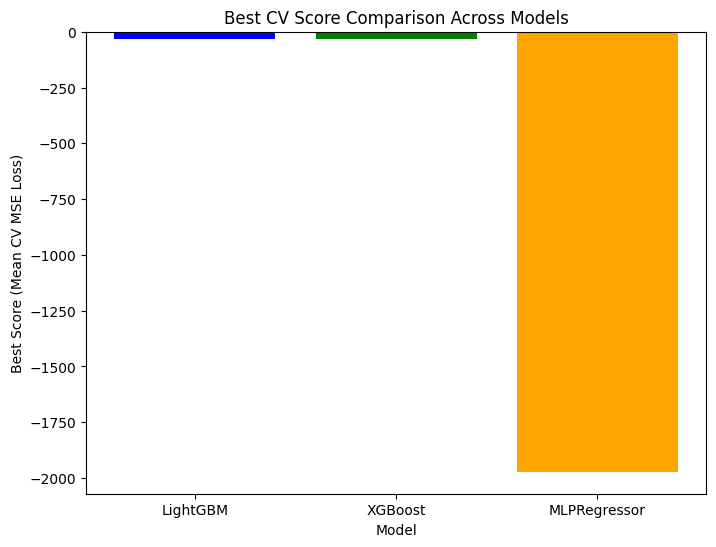

In [43]:
print

# 
# for best_models in all_best_models:

model_names = list(all_best_models.keys())
print(model_names)
best_scores = [all_best_models[model]['best_score'] for model in model_names]

# Plot the scores
plt.figure(figsize=(8, 6))
plt.bar(model_names, best_scores, color=['blue', 'green', 'orange'])
plt.xlabel('Model')
plt.ylabel('Best Score (Mean CV MSE Loss)')
plt.title('Best CV Score Comparison Across Models')
plt.show()


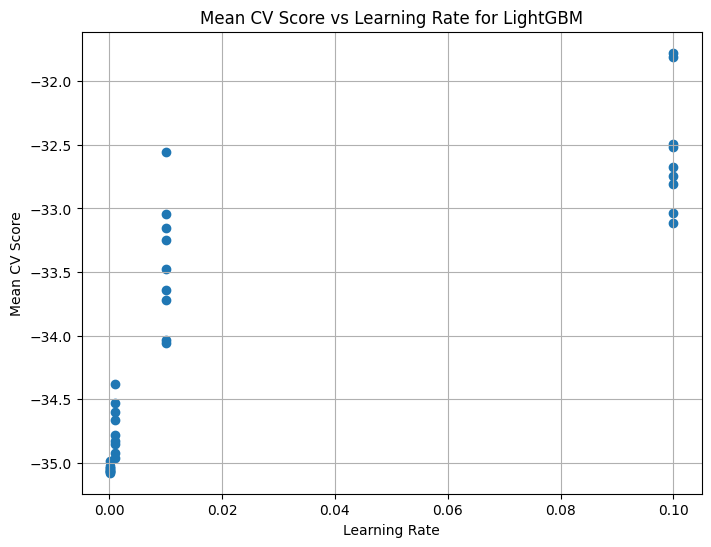

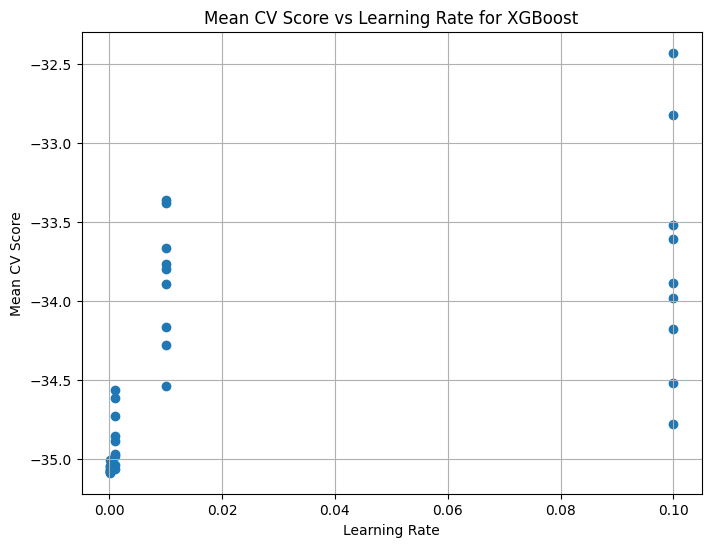

In [35]:
# Example for XGBoost (repeat for other models)
for model_name in model_names[:-1]:
    cv_results_xgb = all_best_models[model_name]['cv_results']
    param_name = 'param_learning_rate'  # Use a different parameter name based on your grid search

    plt.figure(figsize=(8, 6))
    plt.scatter(cv_results_xgb[param_name], cv_results_xgb['mean_test_score'], marker='o')
    plt.xlabel('Learning Rate')
    plt.ylabel('Mean CV Score')
    plt.title(f'Mean CV Score vs Learning Rate for {model_name}')
    plt.grid(True)
    plt.show()


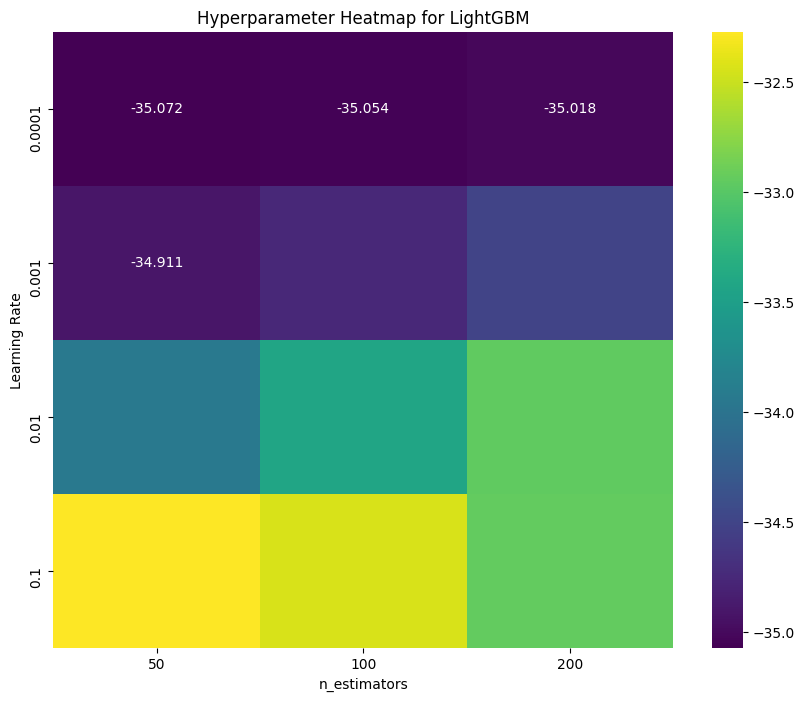

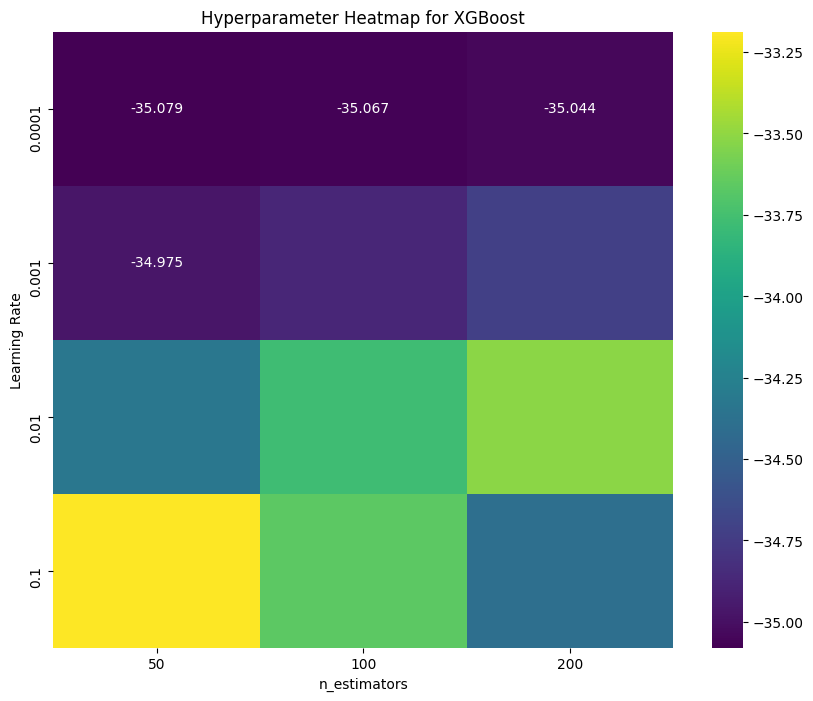

In [40]:
import seaborn as sns
import numpy as np

for model_name in model_names[:-1]:
    cv_results_lgbm = all_best_models[model_name]['cv_results']

    param1 = 'param_learning_rate'
    param2 = 'param_n_estimators'
    pivot_table = cv_results_lgbm.pivot_table(values='mean_test_score', index=param1, columns=param2)

    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="viridis")
    plt.title(f'Hyperparameter Heatmap for {model_name}')
    plt.xlabel('n_estimators')
    plt.ylabel('Learning Rate')
    plt.show()


MLPRegressor
['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_hidden_layer_sizes', 'param_learning_rate_init', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'] 0     -4072.403301
1     -1971.524847
2    -24794.061177
3   -170768.223671
Name: mean_test_score, dtype: float64
['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_hidden_layer_sizes', 'param_learning_rate_init', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'] 0    2
1    1
2    3
3    4
Name: rank_test_score, dtype: int32


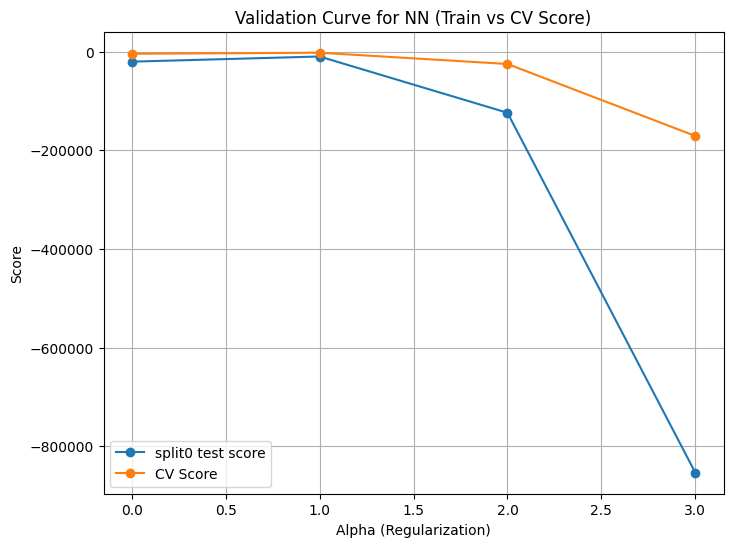

In [49]:
cv_results_nn = all_best_models[model_names[-1]]['cv_results']
param_name = 'hidden_layer_sizes'  # Change this to a relevant parameter for your grid search
# learning_rate_init
print(model_names[-1])
cvnn_keys = list(cv_results_nn.keys())
print(cvnn_keys, cv_results_nn['mean_test_score'])
print(cvnn_keys, cv_results_nn['rank_test_score'])
plt.figure(figsize=(8, 6))
plt.plot(cv_results_nn['split0_test_score'], label='split0 test score', marker='o')
plt.plot( cv_results_nn['mean_test_score'], label='CV Score', marker='o')
plt.xlabel('Alpha (Regularization)')
plt.ylabel('Score')
plt.title('Validation Curve for NN (Train vs CV Score)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
d = {
    "a":1,
    "b":2,
    "c":3
}

for k, v in d.items():
    print(f"{k} : {v}")

In [ ]:
# Inverse transform
y_pred = preprocessor.named_transformers_['num']['scaler'].inverse_transform(y_pred_scaled.reshape(-1, 1))
